# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### 1. Importing libraries and Reading Dataset 


In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Data cleaning 

### portfolio wrangling and cleaning

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
portfolio.shape

(10, 6)

In [8]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [9]:
new_editted_portfolio = portfolio.copy()

In [10]:
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
new_editted_portfolio = pd.concat([new_editted_portfolio, dummy], axis=1)
new_editted_portfolio.drop(columns='channels',inplace = True)

In [11]:
dummy = pd.get_dummies(portfolio.offer_type.apply(pd.Series).stack()).sum(level=0)
new_editted_portfolio = pd.concat([new_editted_portfolio, dummy], axis=1)

In [12]:
new_editted_portfolio.rename(columns={'id':'offer_id'},inplace = True)


In [13]:
new_editted_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### profile wrangling and cleaning

In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [15]:
profile.shape

(17000, 5)

In [16]:
new_editted_profile = profile.copy()

In [17]:
new_editted_profile['became_member_on'] = pd.to_datetime(new_editted_profile['became_member_on'], format='%Y%m%d').dt.date

In [18]:
new_editted_profile.rename(columns={'id':'customer_id'},inplace= True)


In [19]:
new_editted_profile['memberdays']= (datetime.datetime.today().date()-new_editted_profile['became_member_on']).dt.days

In [20]:
new_editted_profile['age']=new_editted_profile['age'].apply(lambda x: np.nan if x==118 else x)

In [21]:
new_editted_profile['gender'].fillna('Na', inplace=True)


In [22]:
new_editted_profile['age_groups'] = pd.cut(new_editted_profile.age, bins=[0, 12, 18, 21, 64, 100], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

In [23]:
new_editted_profile['income'].fillna((new_editted_profile['income'].mean()), inplace=True)


In [24]:
new_editted_profile.head()

,gender,age,customer_id,became_member_on,income,memberdays,age_groups
0,Na,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,1492,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,1339,adult
2,Na,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,977,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,1406,elderly
4,Na,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,1319,NaN


### Transcript wrangling and cleaning


In [25]:
transcript.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [26]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
transcript.iterrows()

<generator object DataFrame.iterrows at 0x7f415e2b5040>

In [28]:
transcript.shape


(306534, 4)

In [29]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [30]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
new_editted_transcript = transcript.copy()

In [32]:
new_editted_transcript.rename(columns={'person':'customer_id'},inplace = True)


In [33]:
new_editted_transcript['event'] = new_editted_transcript['event'].str.replace(' ', '-')


In [40]:
new_editted_transcript

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,0,0,0,1,
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,0,0,0,1,
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,0,0,0,1,
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,0,0,0,1,


In [35]:
dummy = pd.get_dummies(transcript.event.apply(pd.Series).stack()).sum(level=0)

In [36]:
new_editted_transcript = pd.concat([new_editted_transcript, dummy], axis=1 )


In [37]:
def extract_offer_id (df):
    data = []
    for i in df.value:
        if(list(i.keys())[0] in ['offer id','offer_id']):
            data.append(list(i.values())[0])
        else:
            data.append(' ')
    return data

In [41]:
new_editted_transcript ['offer_id'] = extract_offer_id(new_editted_transcript)

In [42]:
def extract_amount (df):
    data = []
    for i in df.value:
        if(list(i.keys())[0] =='amount'):
            data.append(np.round(list(i.values())[0],decimals=2))
        else:
            data.append(0)
    return data

In [43]:
new_editted_transcript ['amount'] = extract_amount(new_editted_transcript)

In [44]:
def extract_reward (df):
    data = []
    for i in df.value:
        if(list(i.keys())[0] =='reward'):
            data.append(np.round(list(i.values())[0],decimals=2))
        else:
            data.append(0)
    return data

In [45]:
new_editted_transcript ['reward'] = extract_reward(new_editted_transcript)

In [46]:
new_editted_transcript

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.00,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,0,0,0,1,,1.59,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,0,0,0,1,,9.53,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,0,0,0,1,,3.61,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,0,0,0,1,,3.53,0


In [47]:
new_editted_transcript.offer_id.isnull().sum()

0

In [48]:
new_editted_transcript = new_editted_transcript.drop('value', axis=1)


In [49]:
new_editted_transcript.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [50]:
first_merge = pd.merge(new_editted_transcript, new_editted_profile, on='customer_id')


In [51]:
first_merge.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward,gender,age,became_member_on,income,memberdays,age_groups
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,F,75.0,2017-05-09,100000.0,1406,elderly
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,F,75.0,2017-05-09,100000.0,1406,elderly
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,,19.89,0,F,75.0,2017-05-09,100000.0,1406,elderly
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,F,75.0,2017-05-09,100000.0,1406,elderly
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,,17.78,0,F,75.0,2017-05-09,100000.0,1406,elderly


In [52]:
full_list = pd.merge(first_merge, new_editted_portfolio, on='offer_id', how='left')


In [53]:
full_list.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,,19.89,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,,17.78,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
full_list.shape

(306534, 27)

In [55]:
full_list.dropna(subset=['offer_id'],inplace=True)

In [56]:
full_list.head()

,customer_id,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,,19.89,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,,17.78,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
full_list.offer_type

0         bogo
1         bogo
2          NaN
3         bogo
4          NaN
          ... 
306529    bogo
306530    bogo
306531    bogo
306532    bogo
306533     NaN
Name: offer_type, Length: 306534, dtype: object

In [58]:
full_list.shape

(306534, 27)

# Data Exploration and Data Visualization :


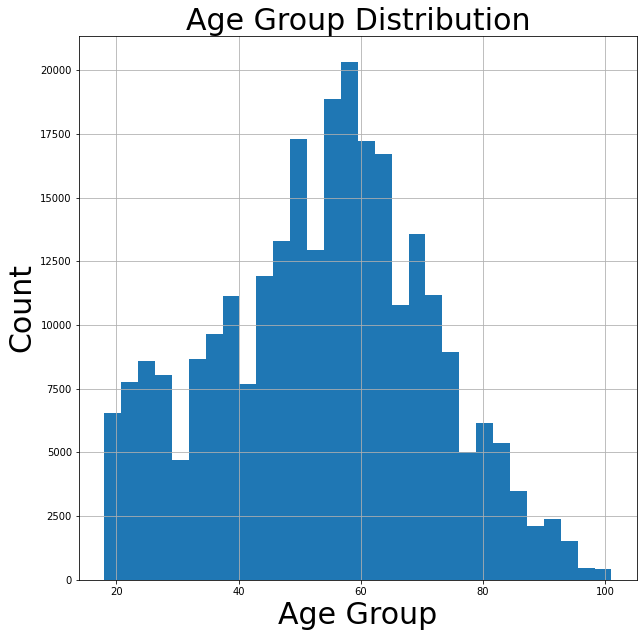

In [59]:
plt.figure(figsize=(10,10))
full_list.age.hist(bins = 30)
plt.xlabel('Age Group',size=30)
plt.ylabel('Count',size=30)
plt.title('Age Group Distribution',size=30);

- most of our data set are with the range between 52 to 60 years

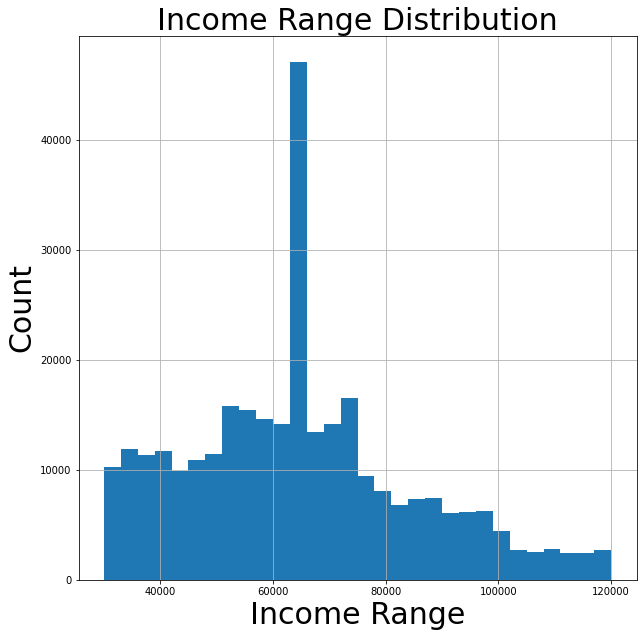

In [60]:
plt.figure(figsize=(10,10))
full_list.income.hist(bins = 30);
plt.xlabel('Income Range',size=30)
plt.ylabel('Count',size=30)
plt.title('Income Range Distribution',size=30);

- average income user is between 65k to 70k

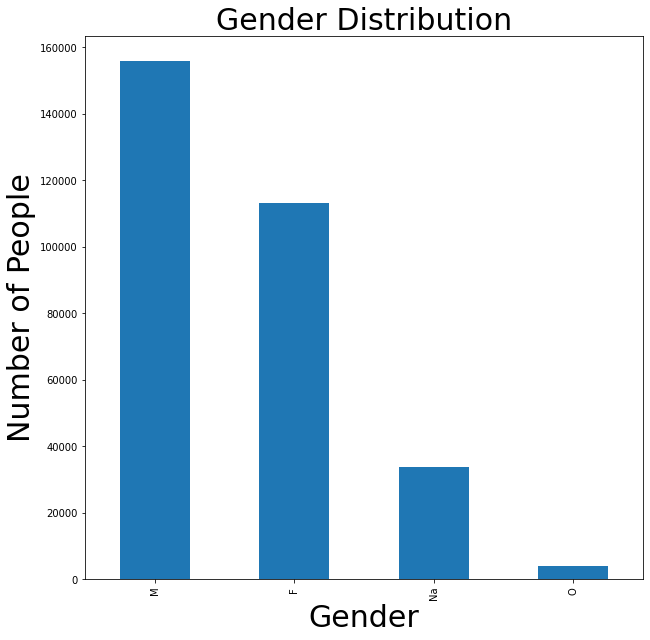

In [61]:
plt.figure(figsize=(10,10))
ax = full_list.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People',size=30)
plt.xlabel('Gender',size=30)
plt.title('Gender Distribution',size=30);

- Males are more than the females by about 20000

In [62]:
full_list.rename(columns={'offer received':'offer_received'},inplace = True)
full_list.rename(columns={'offer viewed':'offer_viewed'},inplace = True)
full_list.rename(columns={'offer completed':'offer_completed'},inplace = True)


Text(0, 0.5, 'Offer Status')

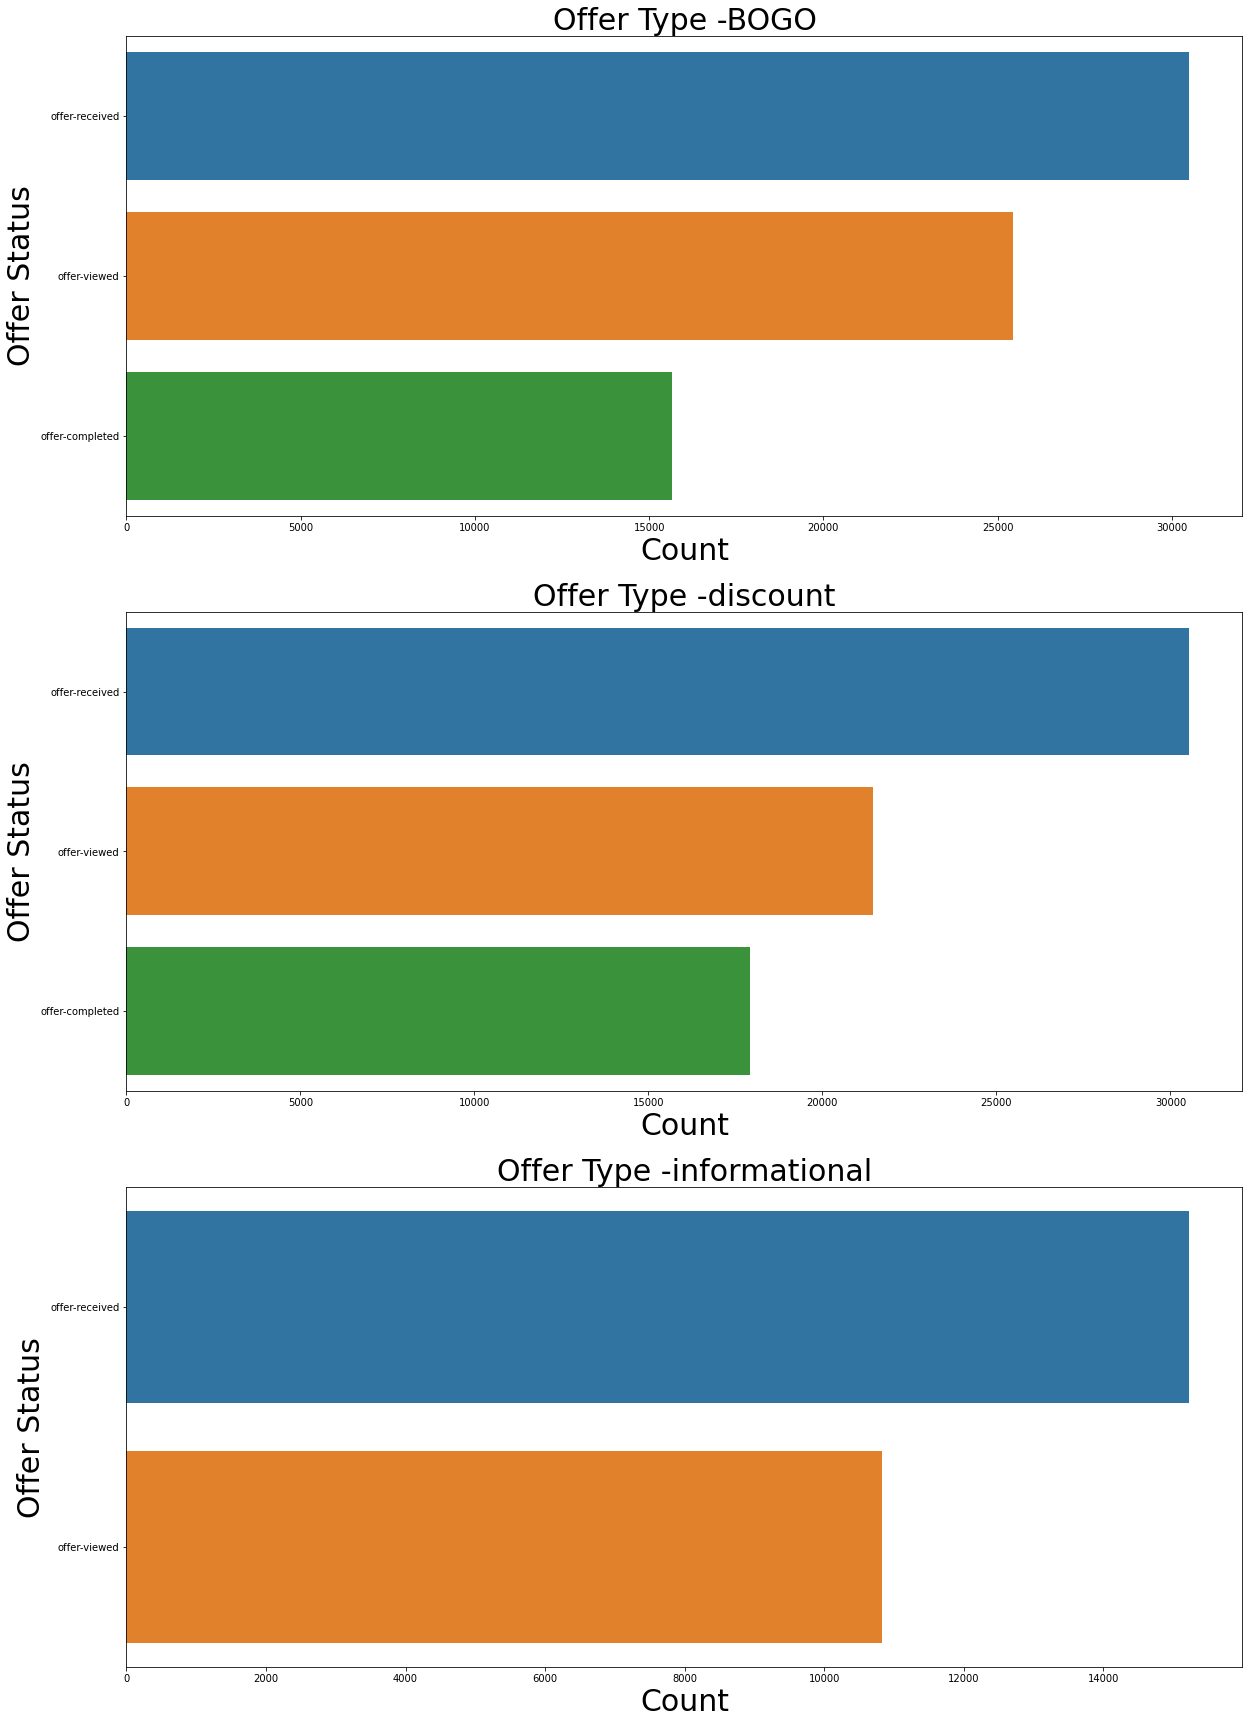

In [63]:
fig, ax =plt.subplots(3,1,figsize=(20,30))
sns.countplot(y=full_list[full_list.bogo == 1].event,ax=ax[0]);
ax[0].set_title('Offer Type -BOGO',fontsize=30)
ax[0].set_xlabel('Count',fontsize=30)
ax[0].set_ylabel('Offer Status',size=30)
sns.countplot(y=full_list[full_list.discount == 1].event,ax=ax[1]);
ax[1].set_title('Offer Type -discount',fontsize=30)
ax[1].set_xlabel('Count',fontsize=30)
ax[1].set_ylabel('Offer Status',size=30)
sns.countplot(y=full_list[full_list.informational == 1].event,ax=ax[2]);
ax[2].set_title('Offer Type -informational',fontsize=30)
ax[2].set_xlabel('Count',fontsize=30)
ax[2].set_ylabel('Offer Status',size=30)

Text(0, 0.5, 'Offer ID')

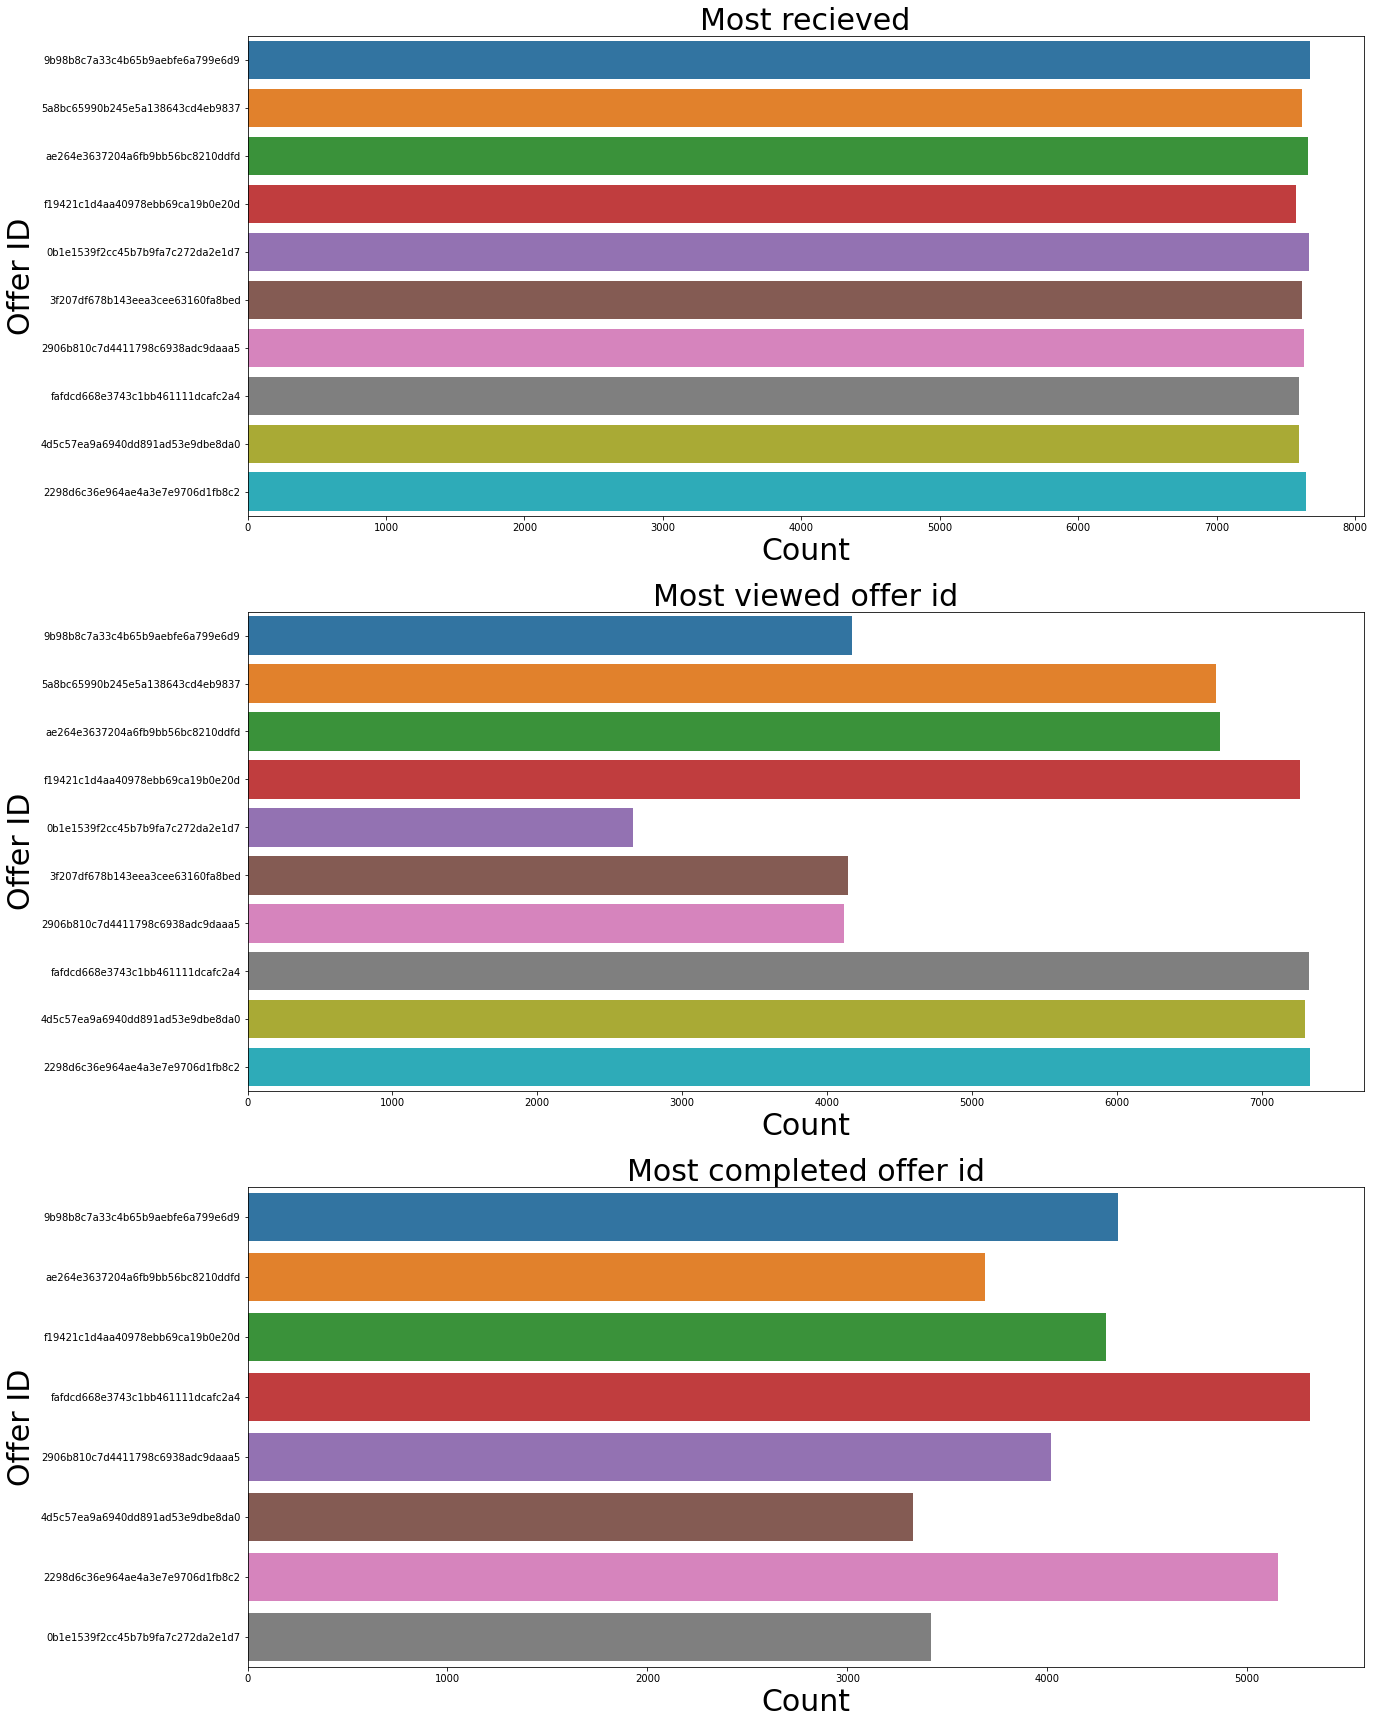

In [64]:
fig, ax =plt.subplots(3,1,figsize=(20,30))
sns.countplot(y=full_list[full_list.event == 'offer-received'].offer_id,ax=ax[0]);
ax[0].set_title('Most recieved',fontsize=30)
ax[0].set_xlabel('Count',fontsize=30)
ax[0].set_ylabel('Offer ID',size=30)
sns.countplot(y=full_list[full_list.event == 'offer-viewed'].offer_id,ax=ax[1]);
ax[1].set_title('Most viewed offer id',fontsize=30)
ax[1].set_xlabel('Count',fontsize=30)
ax[1].set_ylabel('Offer ID',size=30)
sns.countplot(y=full_list[full_list.event == 'offer-completed'].offer_id,ax=ax[2]);
ax[2].set_title('Most completed offer id',fontsize=30)
ax[2].set_xlabel('Count',fontsize=30)
ax[2].set_ylabel('Offer ID',size=30)

- offer completed ratio is not small  

/home/mostafahaggag/Data_science_enviroment/data_science_enviroment/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


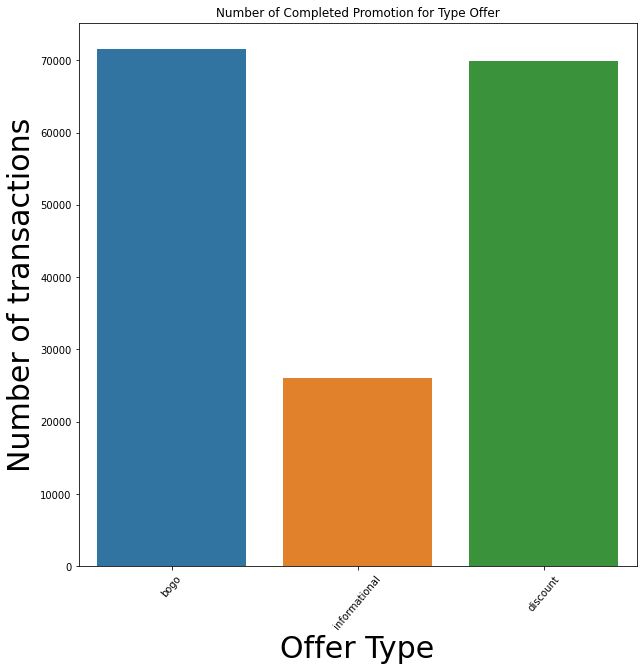

In [65]:
plt.figure(figsize=(10,10))
sns.countplot(full_list[~full_list['offer_type'].isnull()]['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions',fontsize=30)
plt.xlabel('Offer Type',fontsize=30)
plt.xticks(rotation = 50)
plt.show();

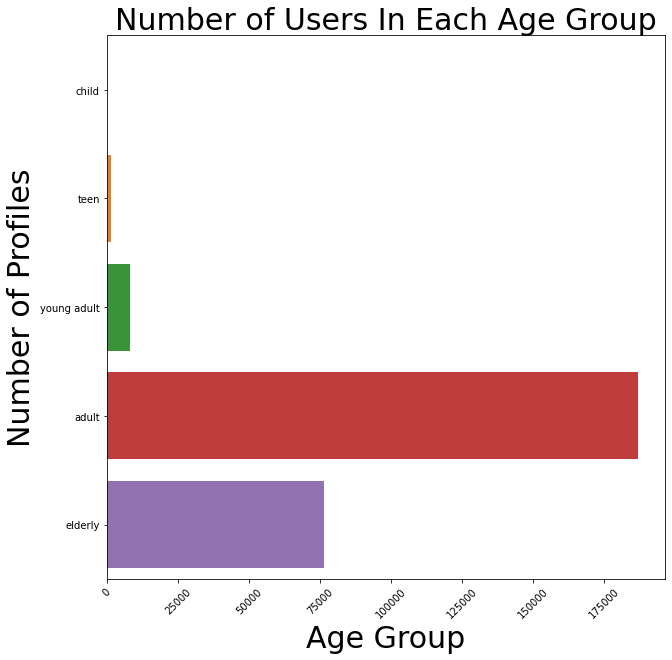

In [66]:
plt.figure(figsize=(10,10))
sns.countplot(y=full_list['age_groups'])
plt.title('Number of Users In Each Age Group',fontsize=30)
plt.ylabel('Number of Profiles',fontsize=30)
plt.xlabel('Age Group',fontsize=30)
plt.xticks(rotation = 45)
plt.show();

Bogo and Discount seem the most and they are close to each other with bogo been slightly higher



In [95]:
df2 = pd.DataFrame(full_list)

In [96]:
df2.head()

,customer_id,event,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount,reward_x,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer-viewed,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,0,0,0,1,,19.89,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer-completed,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,0,0,0,1,,17.78,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   customer_id       306534 non-null  object  
 1   event             306534 non-null  object  
 2   time              306534 non-null  int64   
 3   offer_completed   306534 non-null  uint8   
 4   offer_received    306534 non-null  uint8   
 5   offer_viewed      306534 non-null  uint8   
 6   transaction       306534 non-null  uint8   
 7   offer_id          306534 non-null  object  
 8   amount            306534 non-null  float64 
 9   reward_x          306534 non-null  int64   
 10  gender            306534 non-null  object  
 11  age               272762 non-null  float64 
 12  became_member_on  306534 non-null  object  
 13  income            306534 non-null  float64 
 14  memberdays        306534 non-null  int64   
 15  age_groups        272664 non-null  category
 16  re

In [98]:
df2.drop(["event","time","memberdays",'became_member_on',"offer_id","reward_y"],axis=1,inplace=True)

In [99]:
df2.dropna(inplace=True)

In [100]:
labels_gender = df2['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
df2.replace(replace_map_comp_gender, inplace=True)


In [101]:
labels_age_group = df2['age_groups'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_groups' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
df2.replace(replace_map_comp_age_group, inplace=True)

In [102]:
labels_offer_type = df2['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
df2.replace(replace_map_comp_offer_type, inplace=True)

In [103]:
df2.head()

,customer_id,offer_completed,offer_received,offer_viewed,transaction,amount,reward_x,gender,age,income,...,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0.0,0,1,75.0,100000.0,...,5.0,7.0,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0.0,0,1,75.0,100000.0,...,5.0,7.0,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0.0,0,1,75.0,100000.0,...,5.0,7.0,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0.0,0,1,75.0,100000.0,...,0.0,3.0,3,1.0,1.0,1.0,0.0,0.0,0.0,1.0
6,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0.0,0,1,75.0,100000.0,...,0.0,3.0,3,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [104]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148754 entries, 0 to 306532
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      148754 non-null  object 
 1   offer_completed  148754 non-null  uint8  
 2   offer_received   148754 non-null  uint8  
 3   offer_viewed     148754 non-null  uint8  
 4   transaction      148754 non-null  uint8  
 5   amount           148754 non-null  float64
 6   reward_x         148754 non-null  int64  
 7   gender           148754 non-null  int64  
 8   age              148754 non-null  float64
 9   income           148754 non-null  float64
 10  age_groups       148754 non-null  int64  
 11  difficulty       148754 non-null  float64
 12  duration         148754 non-null  float64
 13  offer_type       148754 non-null  int64  
 14  email            148754 non-null  float64
 15  mobile           148754 non-null  float64
 16  social           148754 non-null  floa

In [105]:
Y = df2['offer_type']
X =df2.drop(['offer_type','customer_id'],axis=1)

In [106]:
X

,offer_completed,offer_received,offer_viewed,transaction,amount,reward_x,gender,age,income,age_groups,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0,1,0,0,0.0,0,1,75.0,100000.0,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,1,0,0.0,0,1,75.0,100000.0,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0,0,0,0.0,0,1,75.0,100000.0,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5,0,1,0,0,0.0,0,1,75.0,100000.0,5,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
6,0,0,1,0,0.0,0,1,75.0,100000.0,5,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306521,0,0,1,0,0.0,0,2,47.0,94000.0,4,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
306522,0,1,0,0,0.0,0,2,47.0,94000.0,4,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
306523,0,0,1,0,0.0,0,2,47.0,94000.0,4,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
306531,0,1,0,0,0.0,0,1,58.0,78000.0,4,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [108]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler


In [110]:

To_scale = MinMaxScaler()
to_normalize = ['age', 'amount', 'reward_x', 'income']

X[to_normalize] = To_scale.fit_transform(X[to_normalize])
X.head()

,offer_completed,offer_received,offer_viewed,transaction,amount,reward_x,gender,age,income,age_groups,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0,1,0,0,0.0,0.0,1,0.695122,0.777778,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,1,0,0.0,0.0,1,0.695122,0.777778,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0,0,0,0.0,0.0,1,0.695122,0.777778,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5,0,1,0,0,0.0,0.0,1,0.695122,0.777778,5,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
6,0,0,1,0,0.0,0.0,1,0.695122,0.777778,5,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [111]:
X.head()

,offer_completed,offer_received,offer_viewed,transaction,amount,reward_x,gender,age,income,age_groups,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0,1,0,0,0.0,0.0,1,0.695122,0.777778,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,1,0,0.0,0.0,1,0.695122,0.777778,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0,0,0,0.0,0.0,1,0.695122,0.777778,5,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
5,0,1,0,0,0.0,0.0,1,0.695122,0.777778,5,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
6,0,0,1,0,0.0,0.0,1,0.695122,0.777778,5,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.40, random_state=42)


In [121]:
# I took this method from this specific refrence: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
def pred_score(model):
    pred = model.predict(X_test)
    errors = abs(pred - y_test)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

In [127]:
neighbourclass = KNeighborsClassifier()

neighbourclass.fit(X_train, y_train)
print(f'This the accuracy of K-NN classifier on training set: {round(neighbourclass.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(neighbourclass)}%')

This the accuracy of K-NN classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


In [128]:
decision_tree_classifieer = DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=2,min_samples_split=90,min_samples_leaf=50)

decision_tree_classifieer.fit(X_train, y_train)
print(f'This the accuracy ofTree classifier on training set: {round(decision_tree_classifieer.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(decision_tree_classifieer)}%')

This the accuracy ofTree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


In [129]:
random_tree_classifieer = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

random_tree_classifieer.fit(X_train, y_train)
print(f'This the accuracy of RandomForestClassifier classifier on training set: {round(random_tree_classifieer.score(X_train, y_train)*100,2)}%.')
y_pred = random_tree_classifieer.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))

This the accuracy of RandomForestClassifier classifier on training set: 100.0%.
1.0


In [130]:
gausico = GaussianNB() 
gausico.fit(X_train, y_train) 
print(f'This the accuracy of SVM classifier on training set: {round(gausico.score(X_train, y_train)*100,2)}%.')
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))

This the accuracy of SVM classifier on training set: 100.0%.
1.0
